В этой работе я провел иерархическую кластеризацию 474 образцов по экспрессии по-разному отобранных генов и проанализировал получившийся результат. В процессе работы были выявлены схожие с оригинальными статьями патерны для каждого из кластеров, но так же имели место и некоторые отличия. 

In [ ]:
pip install lifelines #не убирай меня

     |████████████████████████████████| 348kB 7.8MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp37-none-any.whl size=4035 sha256=5958e74c3d49c9c99f53bbb3ce4e7d9f8e16b9d69de4abebe0581757277326db
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [11]:
pip install mygene 

Note: you may need to restart the kernel to use updated packages.


In [103]:
pip install umap-learn #не убирай меня

  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76570 sha256=66129ff5d28d6ccda8028bf1a34134a98ae09e09ba7aed755b33f60af1f9196b
  Stored in directory: c:\users\khega\appdata\local\pip\cache\wheels\95\85\b7\b4b7040e49367b6d1505d7e8fb57e3e79b22fa6ac26f72520b
  Created wheel for pynndescent: filename=pynndescent-0.5.2-py3-none-any.whl size=51353 sha256=a2c605cfcbb227b789483a8765cbd48d7791a341805aa21445e3a4d174d887d3
  Stored in directory: c:\users\khega\appdata\local\pip\cache\wheels\bb\81\5d\c78c8f15f3c815197129f91ec435d8ae0bb0a7a856d962c3ce
Successfully built umap-learn pynndescent
Note: you may need to restart the kernel to use updated packages.


In [1]:
#не убирай меня
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
import umap
import pandas as pd #работа с таблицами
import matplotlib.pyplot as plt #графики
import seaborn as sns #статистика
import numpy as np #векторы
import scipy.cluster.hierarchy as sci #кластеризация
from lifelines import KaplanMeierFitter #анализ выживаемости
from scipy.spatial.distance import pdist #анализ качества кластеризации
import mygene #для сопоставления генов из разных статей
import warnings #для предупреждений
mg = mygene.MyGeneInfo()

In [6]:
class EXPRESSIONS:
    
    def __init__(self, path_rnaseq, path_patient, path_sample):
        self.rna_seq = pd.read_csv(path_rnaseq, sep = "\t")
        self.data_patient = pd.read_csv(path_patient, sep = "\t")
        self.path_sample = pd.read_csv(path_sample, sep = "\t")

    def gene_distribution(self, gene_names):
        '''
        returns genes' distribution histograms
        
        gene_names - array-like object that contains gene names. GeneFinder is used for the genes to be identified.
        '''
        rna_seq = a.rna_seq.copy() # создаём копию, чтобы избежать лишних проблем
        rna_seq.set_index("Entrez_Gene_Id", inplace= True)
        corrected_names = GeneFinder(gene_names)
        plt.figure(figsize=(12, 7))
        for i, j in zip(corrected_names, range(0, len(corrected_names))):
                #print(i, j, rna_seq.loc[i][2::])
                plt.subplot(2, 2, j+1)
                sns.distplot(rna_seq.loc[int(i)][2::], axlabel = rna_seq.loc[int(i)][0])
    
    def clustering(self, Cophenet = True):
        '''
        Calculating the clusterisation of data based on rna sequencing.
        
        Coherent - showing cophenetic correlation of clusterisation
        '''
        
        rna_seq = self.rna_seq.set_index("Hugo_Symbol").copy() #теперь чтобы обратиться к строке нужно использовать имя гена, а не индекс
        #print(rna_seq)
        rna_mad = rna_seq.drop(['Entrez_Gene_Id'], axis = 1).T.mad()
        rna_seq.insert(1, "mad", np.array(rna_mad))
        
        rna_seq_clast1 = rna_seq.copy() #выделим датасет, в котором проведем класетризацию
        rna_seq_clast1 = rna_seq_clast1.sort_values(["mad"], ascending=False) #отберем наиболее альтернативно экспресируемые гены до z-скорирования,
        # тк оно выравнивает все среднеквадратичные отклонения, а метрика mad ей аналогична
        rna_seq_clast1 = rna_seq_clast1[:1500]
        rna_seq_clast1 = rna_seq_clast1.drop("Entrez_Gene_Id", 1)
        rna_seq_clast1 = rna_seq_clast1.drop("mad", 1)
        rna_seq_clast1 = (rna_seq_clast1.T - rna_seq_clast1.T.median())/rna_seq_clast1.T.std()
        rna_seq_clast1 = rna_seq_clast1.dropna(1) #выбросим гены, вернувшие None
        
        
        
        rna_seq_clast_arr1 = np.array(rna_seq_clast1)
        Z1 = sci.linkage(rna_seq_clast_arr1, 'ward')
        
        if Cophenet:
            c, coph_dists = sci.cophenet(Z1, pdist(rna_seq_clast_arr1))
            print(f'Cophenetic correlation is equal to {c}')

        return CLUSTERING(Z1, rna_seq_clast1)
    
    def deconvolution(self, n = 1):
        '''
        returns umap plot of RNA sequence data.
        
        n - the number of clusters. If n != 1, clusters will be shown on the plot.
        '''
        
        reducer = umap.UMAP()
        
        clusters = self.clustering(Cophenet = False) #создаём объект класса CLUSTERING, чтобы использовать таблицу с отпроцессированными экспрессиями
        embedding = reducer.fit_transform(clusters.expressions)
        #print(embedding.shape, embedding)
        
        plt.figure(figsize=(15, 10))
        
        if n != 1:
            expression_clusterized = clusters.expression_clustering(n) #первый столбец с номерами кластеров
            
            for i in set(expression_clusterized["Cluster"]):
                temp = embedding[expression_clusterized["Cluster"] == i]
                plt.scatter(temp.T[0], temp.T[1], s = 100)
        else:
            plt.scatter(embedding.T[0], embedding.T[1])
        
        plt.show()

            
def GeneFinder(genes):
    '''
    returns entrezgene ID
    
    genes - array-like object of gene names
    '''
    
    genes_ID = []
    for gene in genes:
        if mg.query(gene, fields='entrezgene')['hits']:
            try:
                genes_ID.append(mg.query(gene, fields='entrezgene')['hits'][0]['entrezgene'])
            except (KeyError):
                warnings.warn('Gene {} not found'.format(gene))
                pass
        else:
            warnings.warn('Gene {} not found'.format(gene))
    return (genes_ID)

In [3]:
class CLUSTERING:
    def __init__(self, Z, expressions):
        """
        class for cluterized data
        Z - scoring output
        expressions - pd.dataframe with IDs and expressions
        """
        self.Z = Z
        self.expressions = expressions
        
    def dendogram(self, y = False):
        """
        Build dendogram for hierachial clustering
        param:
        y - cutline
        """
        plt.figure(figsize=(25, 10)) #строим двоичное дерево для нормированных данных
        plt.title('Кластеризация нормированных данных')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        sci.dendrogram(
          self.Z,
          leaf_rotation=9.,  
          leaf_font_size=2., 
        )
        if y:
            plt.axhline(y=y, c='r')
        plt.show()
  
    def expression_clustering(self, n):
        """
        returns expression table with clusters
        param:
        n - number of slusters the data will be clusterized
        """
        clasters = sci.fcluster(self.Z, n, criterion='maxclust')
        expression_clusterized = self.expressions.copy()
        expression_clusterized.insert(0, "Cluster", np.array(clasters))
        return (expression_clusterized)
    
    def sample_clustering(self, n, samples):
        """
        returns sample table with clusters
        param:
        n - number of clusters
        samples - pd.dataframe with samples without service rows
        """
        expression_clusterized = self.expression_clustering(n)
        sample_proc = samples.copy()
        indexes = list(set(sample_proc.index).intersection(set(expression_clusterized.index)))
        sample_proc.insert(0, "Cluster", -1)
        for ind in indexes:
            sample_proc["Cluster"][ind] = expression_clusterized["Cluster"][ind]
        broken = sample_proc[sample_proc["Cluster"] == -1].index
        if len(broken):
            warnings.warn('{} samples were droped'.format(len(broken)))
        sample_proc.drop(broken, inplace = True)
        return (sample_proc)
    
    def patient_clustering(self, n, samples, patients):
        """
        returns patient table with clusters
        param:
        n - number of clusters
        samples - pd.dataframe with samples without service rows
        patients - pd.dataframe with patients without service rows
        """
        sample_proc = self.sample_clustering(n, samples)
        patients_proc = patients.copy()
        patients_proc.insert(0, "Cluster", -1)
        for ind in sample_proc.index:
            patients_proc['Cluster'][sample_proc['#Patient Identifier'][ind]] = sample_proc['Cluster'][ind]
        broken = patients_proc[patients_proc["Cluster"] == -1].index
        if len(broken):
            warnings.warn('{} patient forms were droped'.format(len(broken)))
        patients_proc.drop(broken, inplace = True)
        return patients_proc
    
    def Caplan_Meier(self, n, samples, patients, ci_show = False):
        """
        returns Caplan_Meier diagram with track for each cluster
        param:
        n - number of clusters
        samples - pd.dataframe with samples without service rows
        patients - pd.dataframe with patients without service rows
        """
        patients_proc = self.patient_clustering(n, samples, patients)
        patients_proc.drop(patients_proc[patients_proc['Overall Survival (Months)'] == '[Not Available]'].index, inplace = True)
        events = []
        durations = []
        km = []
        plt.figure(figsize=(25, 10))
        for i in range (n):
            events = list(patients_proc['Overall Survival Status'][patients_proc['Cluster'] == i+1].apply(lambda x: int(x[0])))
            durations = list(patients_proc['Overall Survival (Months)'][patients_proc['Cluster'] == i+1].apply(float))
            kk = KaplanMeierFitter()
            km.append(kk.fit(np.array(durations)/12, events, label='claster {}'.format(i+1)))
        for i in range (n):
            km[i].plot(ci_show=ci_show)
        plt.title('Survival analysis, {} clusters'.format(n), size = 15)
        plt.xlabel('Time, years', size = 15)
        plt.ylabel('Survival rate', size = 15)
        #return (km)
    
    def Heat_Map_Overexpression(self, n, *args):
        """
        returns heatmap with overexpressed genes
        param - number of clusters
        *args - threshold of overexpression for each cluster
        """
        exp = self.expression_clustering(n)
        gene_lists = []
        for i in range (1, n+1):
            exp_i = exp[exp['Cluster'] == i].copy()
            for j in list(exp_i.columns)[1:]:
                if exp_i[j].mean() > exp[j].mean() + thresholds[i-1]:
                    gene_lists.append(j)
        
        plt.figure(figsize=(20, 10))
        plt.title('Upregulation heatmap', size = 15)
        ax = sns.heatmap(exp.sort_values(["Cluster"], ascending=True)[gene_lists], cmap="ocean")
        
    def Heat_Map_Downexpression(self, n, *args):
        """
        returns heatmap with overexpressed genes
        param - number of clusters
        *args - threshold of overexpression for each cluster
        """
        exp = self.expression_clustering(n)
        gene_lists = []
        for i in range (1, n+1):
            exp_i = exp[exp['Cluster'] == i].copy()
            for j in list(exp_i.columns)[1:]:
                if exp_i[j].mean() < exp[j].mean() - thresholds[i-1]:
                    gene_lists.append(j)
        plt.figure(figsize=(20, 10))
        plt.title('Downregulation heatmap', size = 15)
        ax = sns.heatmap(exp.sort_values(["Cluster"], ascending=True)[gene_lists], cmap="ocean")

In [97]:
# class PATIENTS:
#     def __init__(self, path_rna_seq, path_sample):
#         '''
#         path_patient - path to the table with info about patients
#         '''
        
#         self.rna_seq = pd.read_csv(path_rna_seq, sep = "\t")
#         self.data_sample = pd.read_csv(path_sample, sep = "\t")
        
#     def 
    
#     def volcano_plot(self, patient):
#         '''
#         patient - Patient Identifier in "data_bcr_clinical_data_sample.txt"
#         '''
#         sample = self.data_sample[self.data_sample["#Patient Identifier"] == patient]["Sample Identifier"].values[0]
        
#         log2_fold_change = np.log2(self.rna_seq[sample]/self.rna_seq.mean(1))
        
#         #print(patient, sample)
        
#         minlog10_pvalue = []
#         for ind in self.rna_seq.index:
#             try:
#                 #minlog10_pvalue.append(-np.log10(mannwhitneyu([self.rna_seq.loc[ind][sample]],
#                 #                                          self.rna_seq.loc[ind][2:],
#                 #                                             alternative='two-sided').pvalue))
#             except (ValueError):
#                 minlog10_pvalue.append(0)
        
#         plt.figure(figsize = (10, 10))
#         plt.title("volcano", fontsize = 20)
#         plt.scatter(log2_fold_change, minlog10_pvalue)
#         plt.xlabel('log2_fold_change', fontsize = 20)
#         plt.ylabel('-log10_P_value', fontsize = 20)

In [106]:
# a = PATIENTS("data_RNA_Seq_v2_expression_median.txt", "data_bcr_clinical_data_sample.txt")

In [12]:
#не убирай меня
rna_seq = pd.read_csv("data_RNA_Seq_v2_expression_median.txt", sep = "\t")
data_patient = pd.read_csv("data_bcr_clinical_data_patient.txt", sep = "\t")
data_sample = pd.read_csv("data_bcr_clinical_data_sample.txt", sep = "\t")

In [13]:
#не убирай меня
data_patient_proc = data_patient.set_index("Patient Identifier")
data_patient_proc = data_patient_proc.drop(["Clark level at diagnosis", "American Joint Committee on Cancer Publication Version Type", 'American Joint Committee on Cancer Tumor Stage Code', 'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code', 
                                           'Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage', "Neoplasm American Joint Committee on Cancer Clinical Regional Lymph Node N Stage", 'Neoplasm American Joint Committee on Cancer Clinical Primary Tumor T Stage', 
                                           'Neoplasm American Joint Committee on Cancer Clinical Group Stage', 'Project code', 'Disease code', 'Neoadjuvant Therapy Type Administered Prior To Resection Text', 'Neoplasm Disease Stage American Joint Committee on Cancer Code', 'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
                                           "Informed consent verified", "International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code", 'ICD-10 Classification'], 1)
data_patient_proc = data_patient_proc.drop(['Identifier to uniquely specify a patient.', 'STRING', '1', 'PATIENT_ID'], 0)

In [14]:
#не убирай меня
data_sample_proc = data_sample.set_index("Sample Identifier")
data_sample_proc = data_sample_proc.drop(["Other Sample ID", 'Specimen Current Weight', 'Days to Sample Collection.', 'Days to Sample Procurement', 'Specimen Freezing Means', 'Sample Initial Weight', 
                       'Specimen Second Longest Dimension', 'Longest Dimension', "First Pathologic Diagnosis Biospecimen Acquisition Method Type", 
                       "Specimen Collection Method", 'Pathology Report File Name', 'Pathology report uuid', 'Shortest Dimension', "Time between clamping and freezing", 'Time between excision and freezing', 
                       'Oncotree Code'], 1)
data_sample_proc = data_sample_proc.drop(['A unique sample identifier.', 'STRING', '1', 'SAMPLE_ID'], 0)

In [9]:
pd.read_csv("data_bcr_clinical_data_patient.txt", sep = "\t")

,#Other Patient ID,Patient Identifier,Form completion date,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Sex,Patient Height,Patient Weight,Race Category,Ethnicity Category,...,"International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code",Informed consent verified,Project code,Stage Other,Tissue Source Site,Tumor tissue site other,Overall Survival Status,Overall Survival (Months),Disease Free Status,Disease Free (Months)
0,#Legacy DMP patient identifier (DMPnnnn),Identifier to uniquely specify a patient.,Form completion date,Text indicator for the time frame of tissue pr...,Text indicator for the time frame of tissue pr...,Sex,Height in centimeters.,Weight measured in kilograms.,The text for reporting information about race.,The text for reporting information about ethni...,...,The third edition of the International Classif...,Informed consent verified,Project code,Stage Other,"A Tissue Source Site collects samples (tissue,...",Tumor tissue site other,Overall patient survival status.,Overall survival in months since initial diago...,Disease free status since initial treatment.,Disease free (months) since initial treatment.
1,#STRING,STRING,STRING,STRING,STRING,STRING,NUMBER,NUMBER,STRING,STRING,...,STRING,STRING,STRING,STRING,STRING,STRING,STRING,NUMBER,STRING,NUMBER
2,#1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,OTHER_PATIENT_ID,PATIENT_ID,FORM_COMPLETION_DATE,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,HEIGHT,WEIGHT,RACE,ETHNICITY,...,ICD_O_3_SITE,INFORMED_CONSENT_VERIFIED,PROJECT_CODE,STAGE_OTHER,TISSUE_SOURCE_SITE,TUMOR_TISSUE_SITE_OTHER,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
4,5564E6A7-2195-4B0D-994E-B0617B58E889,TCGA-3N-A9WB,5/29/14,YES,NO,Male,175,78,WHITE,NOT HISPANIC OR LATINO,...,C44.5,YES,[Not Available],[Not Available],3N,[Not Applicable],1:DECEASED,17.02,1:Recurred/Progressed,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,19E9BA4B-8F8E-4899-B667-B49FDD7EF6F4,TCGA-YG-AA3O,6/5/14,YES,NO,Male,173,92,[Not Available],HISPANIC OR LATINO,...,C77.3,YES,[Not Available],[Not Available],YG,[Not Applicable],1:DECEASED,37.91,1:Recurred/Progressed,32.82
470,F1713C39-26B8-4667-A08B-F8CF6D2B8E13,TCGA-YG-AA3P,5/23/14,YES,NO,Female,160,64,[Not Available],HISPANIC OR LATINO,...,C49.6,YES,[Not Available],[Not Available],YG,[Not Applicable],0:LIVING,14.42,0:DiseaseFree,14.42
471,590B5E18-D837-4C0E-BECF-80520DB57C0F,TCGA-Z2-A8RT,6/30/14,YES,NO,Female,155,77,WHITE,NOT HISPANIC OR LATINO,...,C44.6,YES,[Not Available],[Not Available],Z2,[Not Applicable],0:LIVING,27.56,0:DiseaseFree,27.56
472,71B347AC-6AC6-475D-8E21-754764180948,TCGA-Z2-AA3S,6/30/14,YES,NO,Male,172,78,WHITE,NOT HISPANIC OR LATINO,...,C77.3,YES,[Not Available],[Not Available],Z2,[Not Applicable],0:LIVING,96.91,1:Recurred/Progressed,93.5


In [84]:
pd.read_csv("data_RNA_Seq_v2_expression_median.txt", sep = "\t")

,Hugo_Symbol,Entrez_Gene_Id,TCGA-3N-A9WB-06,TCGA-3N-A9WC-06,TCGA-3N-A9WD-06,TCGA-BF-A1PU-01,TCGA-BF-A1PV-01,TCGA-BF-A1PX-01,TCGA-BF-A1PZ-01,TCGA-BF-A1Q0-01,...,TCGA-XV-AB01-06,TCGA-YD-A89C-06,TCGA-YD-A9TA-06,TCGA-YD-A9TB-06,TCGA-YG-AA3N-01,TCGA-YG-AA3O-06,TCGA-YG-AA3P-06,TCGA-Z2-A8RT-06,TCGA-Z2-AA3S-06,TCGA-Z2-AA3V-06
0,LOC100130426,100130426,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.5522,0.0000,0.0000,0.0000,0.0000,0.0000
1,UBE2Q2P3,100133144,4.4709,5.2474,5.3404,0.3247,3.1889,0.5353,1.3536,22.9168,...,0.0000,18.4309,42.3337,5.3220,0.5522,20.1673,0.6713,8.6977,3.2313,2.7530
2,UBE2Q2P3,100134869,6.4338,8.0016,3.8794,0.0000,3.3861,1.2026,3.8408,15.8059,...,0.0000,67.8283,43.9516,13.8371,4.4174,7.8851,2.5253,2.5426,3.3926,2.4783
3,LOC149767,10357,143.5703,84.6612,118.8794,92.8766,163.9868,121.2026,161.8639,133.9102,...,28.7741,257.5899,332.2118,122.2246,68.4705,75.8395,97.4853,103.9767,120.7776,29.0011
4,TIMM23,10431,1224.5557,560.4738,629.7872,544.8052,771.0699,793.5349,988.7709,988.4853,...,388.4298,787.1695,512.6559,655.6679,691.8829,773.6375,709.6430,706.2016,366.0451,514.6314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20526,ZYX,7791,1236.2682,3594.4996,3270.2128,5132.1429,5128.2128,4675.7039,3177.7557,10974.0171,...,11526.1708,5296.0555,3701.5035,3021.2879,10181.1154,3125.3063,1925.4129,2865.1163,2136.9429,11832.5977
20527,FLJ10821,23140,622.7787,883.6696,1105.6738,1796.1039,1097.4298,1398.3316,1648.7663,1287.7062,...,1464.1873,852.6225,1245.0696,1078.7653,2362.7830,2671.3984,1480.5541,1849.6124,1640.4349,1413.1110
20528,ZZZ3,26009,721.3247,1137.8099,769.5035,286.0390,1658.9958,521.0288,651.4399,858.2361,...,224.5179,743.3897,958.9125,741.8840,1066.8139,940.5999,1003.7294,454.2636,1452.3724,102.0108
20529,HUMRTVLH3,387590,2.8271,4.8178,197.1631,2.5974,1.7932,328.4672,0.9167,5.6324,...,20.6612,0.8669,4.3817,5.3220,19.8785,3.7178,11.1881,5.4264,3.1680,32.0419


In [7]:
a = EXPRESSIONS("data_RNA_Seq_v2_expression_median.txt", "data_bcr_clinical_data_patient.txt", "data_bcr_clinical_data_sample.txt")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


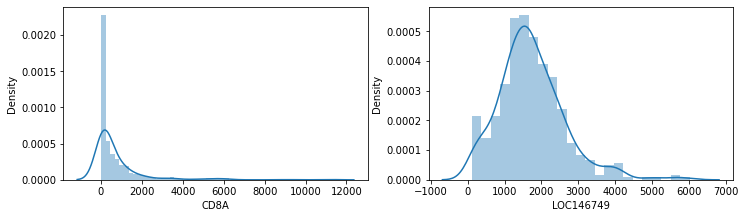

In [83]:
a.gene_distribution(["CD8A", "TP53"])

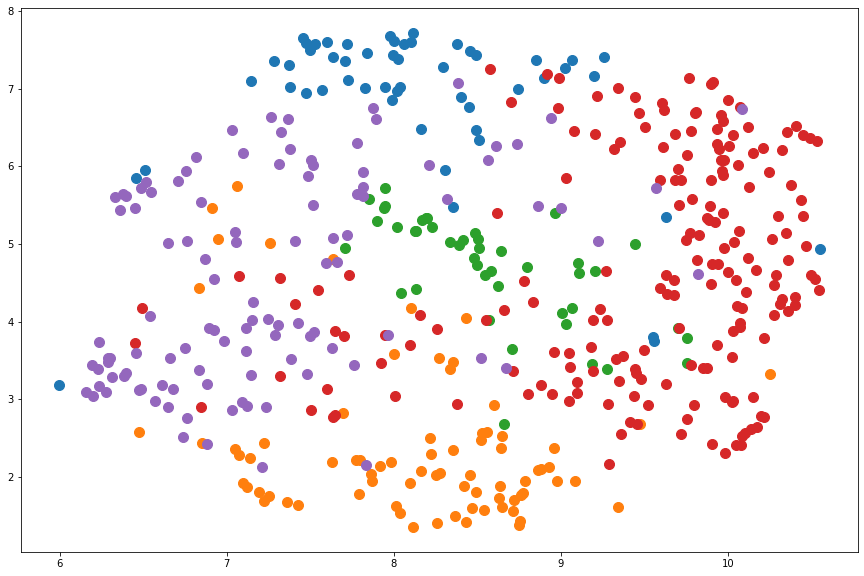

In [8]:
a.deconvolution(5)

In [11]:
b = a.clustering()

Cophenetic correlation is equal to 0.5528767865474054


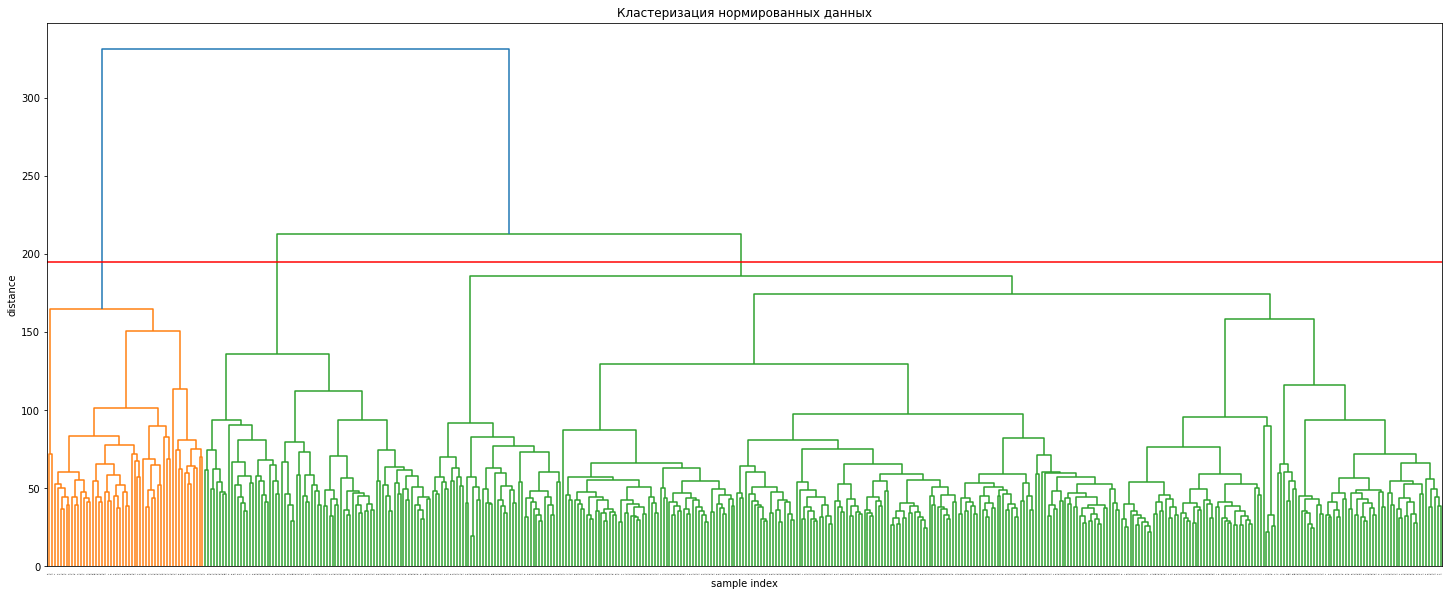

In [14]:
b.dendogram(y = 195)

In [128]:
b.expression_clustering(3)#.sort_values(["Cluster"], ascending=True)

Hugo_Symbol,Cluster,D12S53E,ADAM6,GAPDH,CD74,FN1,VIM,OI4,BMS1P20,APOD,...,C21orf112,COX7C,LOC115390,LTBR,LOC643556,WLS,NARS,ENDOD1,PLEKHH1,RENBP
TCGA-3N-A9WB-06,3,0.511567,-0.059269,2.013903,-0.378939,-0.453835,1.206173,-0.008704,-0.055143,-0.110200,...,0.257587,2.667063,-0.625413,0.637517,0.820340,0.347086,-0.102687,-0.178541,0.062865,2.065948
TCGA-3N-A9WC-06,3,-0.507717,0.680521,-0.025051,1.834639,-0.109611,-0.905992,-0.025823,0.359784,0.065984,...,-1.343517,0.936955,-0.459478,-0.085278,0.947903,0.762234,0.365710,0.581173,-0.256473,0.007796
TCGA-3N-A9WD-06,3,-0.272235,0.780726,0.126553,0.403391,0.871195,-0.499393,-0.091279,0.302421,-0.083828,...,-1.083714,1.512612,-0.010326,0.482369,0.790356,0.362180,0.017306,-0.235344,-0.016583,-0.523235
TCGA-BF-A1PU-01,1,1.031365,-0.067110,0.460343,-0.350882,1.670685,0.383492,0.182547,-0.057338,0.644116,...,0.408034,0.218149,2.272932,0.006495,-0.854452,-0.969362,1.114624,0.087226,1.861169,0.790393
TCGA-BF-A1PV-01,3,-0.142724,-0.022456,-0.621047,-0.349568,4.252442,1.954405,-0.000107,-0.025393,-0.120916,...,0.198674,-0.825097,3.700035,0.836708,-0.189271,-0.040202,1.328230,0.079953,-0.075936,-0.266523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YG-AA3O-06,3,0.308249,-0.035687,-0.294907,-0.191849,0.258820,-0.130111,0.118251,0.034470,0.123442,...,-1.181887,0.534037,-0.096031,-0.063793,0.840709,-0.129543,0.257673,-0.164741,0.570491,-0.163421
TCGA-YG-AA3P-06,3,-0.506745,-0.062243,2.342948,-0.325078,-0.509056,1.539480,-0.171836,-0.037081,-0.153120,...,2.845305,1.225536,-0.497377,-0.343341,0.859970,-0.626740,0.813403,-0.656116,0.634609,0.964280
TCGA-Z2-A8RT-06,3,0.130203,0.224683,-0.337353,0.252721,0.003096,1.175533,-0.028868,0.198601,0.140327,...,-0.119689,-0.490970,-0.593793,-0.419992,0.595346,-0.397927,-0.587728,0.865208,-0.001796,1.635672
TCGA-Z2-AA3S-06,3,-0.287207,-0.047228,-0.737584,-0.229420,-0.546788,-1.045987,-0.176611,-0.022566,-0.083852,...,0.972592,0.324473,-0.664463,-0.117312,0.731133,1.540653,0.970656,-0.292105,0.402281,0.135227


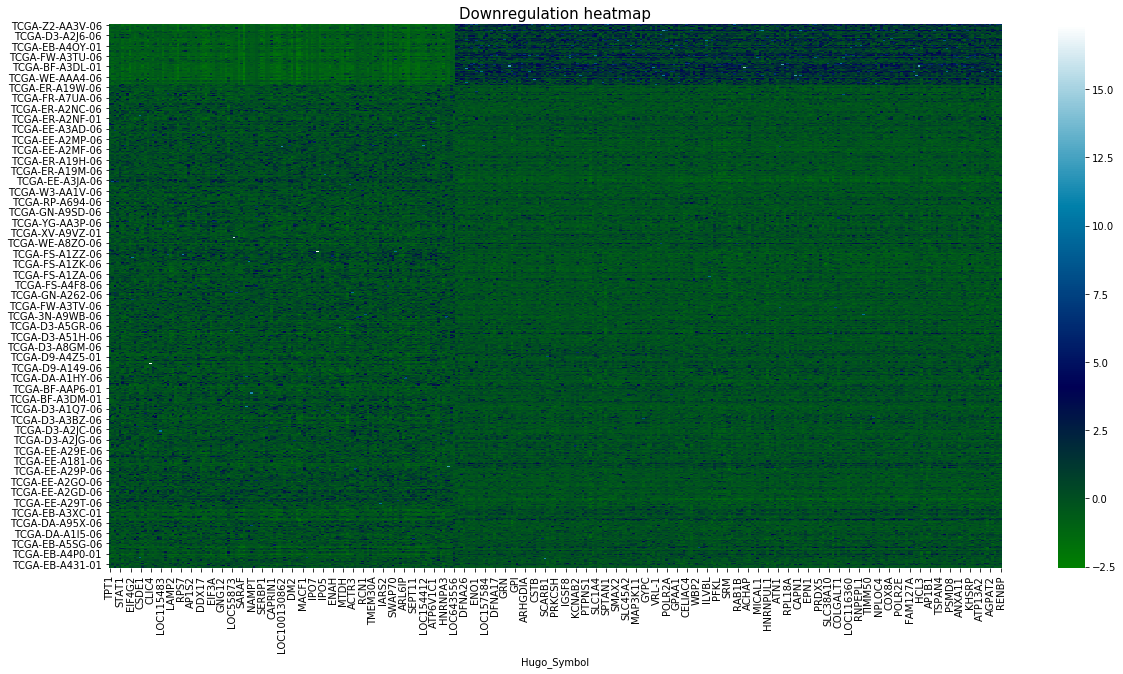

In [162]:
thresholds = (0.6, 0.15)
b.Heat_Map_Downexpression(2, thresholds)

C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: 8 samples were droped
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:76: UserWarning: 1 patient forms were droped


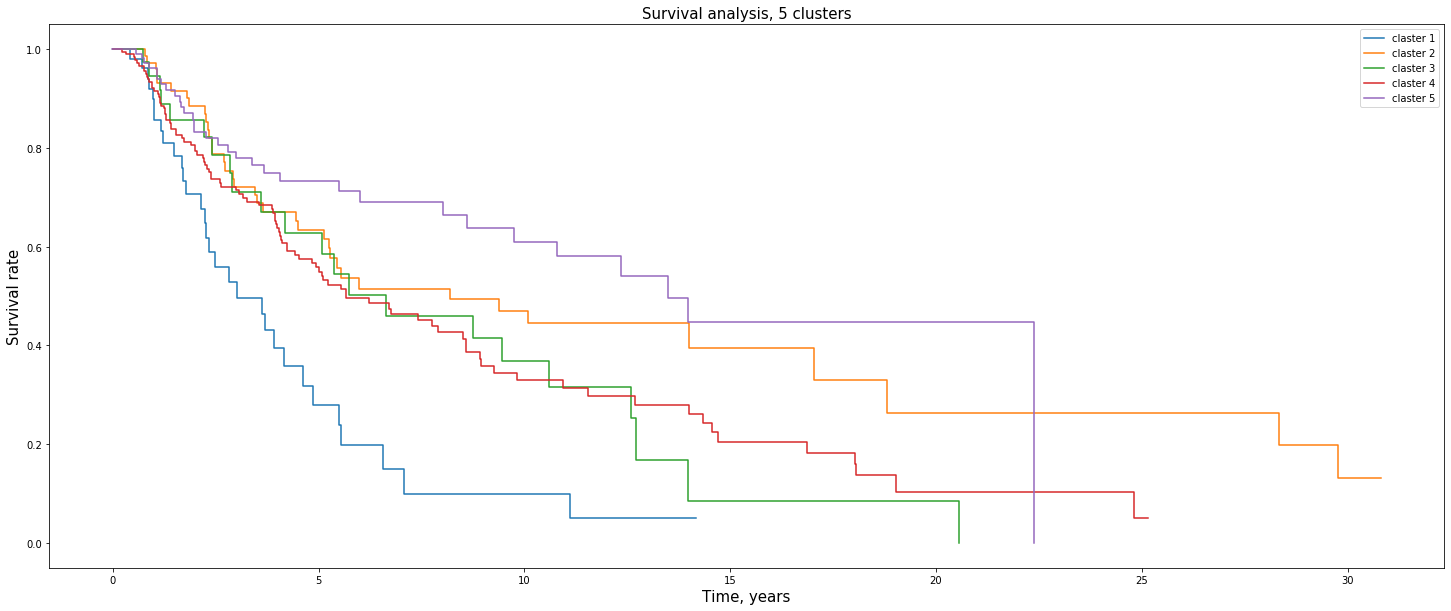

In [164]:
b.Caplan_Meier(5, data_sample_proc, data_patient_proc)

C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: 8 samples were droped
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\luppo\anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: 1 patient forms were droped


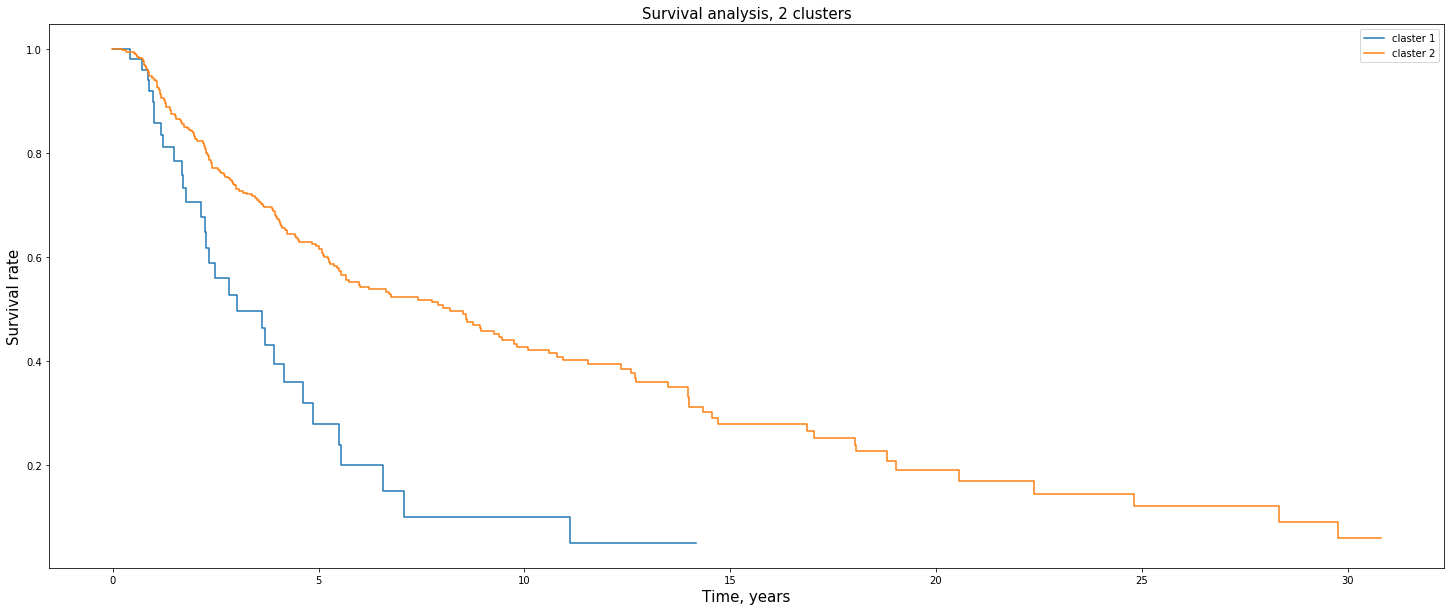

In [117]:
km = b.Caplan_Meier(2, data_sample_proc, data_patient_proc)